In [1]:
import os
import re
import rasterio
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import segmentation_models_pytorch as smp
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
def find_tiff_file(directory):
    """Находит первый .tiff файл в указанной директории с помощью регулярного выражения"""
    tiff_pattern = re.compile(r'.*\.tiff$')  # Регулярное выражение для поиска .tiff файлов
    for file_name in os.listdir(directory):
        if tiff_pattern.match(file_name):
            return os.path.join(directory, file_name)
    raise FileNotFoundError("TIFF файл не найден в указанной директории")

def normalize_band(band):
    """Нормализует данные канала в диапазоне 0-255"""
    band_min, band_max = band.min(), band.max()
    normalized_band = (band - band_min) / (band_max - band_min) * 255.0
    return normalized_band.astype(np.uint8)

def visualize_rgb_geotiff(directory, r_band, g_band, b_band, ik_band, mask_band):
    try:
        # Поиск .tiff файла в указанной папке
        file_path = find_tiff_file(directory)
        print(f"Обнаружен файл: {file_path}")

        with rasterio.open(file_path) as src:

            print(f"File Path: {file_path}")
            print(f"Driver: {src.driver}")
            print(f"Width: {src.width}")
            print(f"Height: {src.height}")
            print(f"Count (Bands): {src.count}")
            print(f"CRS: {src.crs}")
            print(f"Transform: {src.transform}")
            print(f"Bounding Box: {src.bounds}")
            print(f"Datum: {src.dtypes}")

            for i in range(1, src.count + 1):
                band = src.read(i)
                print(f"\nBand {i}:")
                print(f"  Data Type: {src.dtypes[i - 1]}")
                print(f"  Min Value: {band.min()}")
                print(f"  Max Value: {band.max()}")
                print(f"  Mean Value: {band.mean()}")
                print(f"  Standard Deviation: {band.std()}")
                
            # Проверка количества доступных каналов
            num_bands = src.count
            print(f"Number of bands: {num_bands}")
            if r_band > num_bands or g_band > num_bands or b_band > num_bands or ik_band > num_bands or mask_band > num_bands:
                raise ValueError("Номера каналов превышают количество доступных в файле.")

            # Чтение необходимых каналов
            red = src.read(r_band)
            green = src.read(g_band)
            blue = src.read(b_band)
            ik = src.read(ik_band)
            mask = src.read(mask_band)

            # Нормализация каждого канала
            red_norm = normalize_band(red)
            green_norm = normalize_band(green)
            blue_norm = normalize_band(blue)

            # Сборка RGB изображения
            photo_rgb = np.stack([red_norm, green_norm, blue_norm], axis=-1).astype(np.uint8)

            # Обработка маски
            mask_stacked = (mask > 0).astype(np.uint8) * 255  # Преобразование маски в бинарную

            # Определение имени файлов для сохранения
            base_name = os.path.splitext(os.path.basename(file_path))[0]  # Имя файла без расширения
            output_dir = os.path.dirname(file_path)  # Получаем директорию исходного файла
            
            filename = os.path.join(output_dir, f"{base_name}_photo_rgb.jpg")
            filename_mask = os.path.join(output_dir, f"{base_name}_mask.jpg")

            # Сохранение файлов
            cv2.imwrite(filename, photo_rgb)
            cv2.imwrite(filename_mask, mask_stacked)

            # Визуализация изображений
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(photo_rgb)
            ax.axis('off')
            plt.show()

            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(mask_stacked, cmap='gray')
            ax.axis('off')
            plt.show()

    except FileNotFoundError as fnf_error:
        print(fnf_error)
    except Exception as e:
        print(f'Ошибка: {e}')

# Директория с GeoTIFF файлами
directory = '/home/user/projects/co_hack_fires/train/00/'
# Вызов функции для визуализации
visualize_rgb_geotiff(directory, 1, 2, 3, 4, 5)


In [ ]:
%pip install segmentation_models.pytorch 

## обучение нейронной сети

In [2]:
class SegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform_image=None, transform_mask=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform_image = transform_image
        self.transform_mask = transform_mask
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])  # имена изображений и масок должны совпадать
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Маска - одноканальное изображение

        if self.transform_image:
            image = self.transform_image(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)

        return image, mask


In [3]:
resize = transforms.Resize((256, 256))
transform_image = transforms.Compose([
    resize,
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transform_mask = transforms.Compose([
    resize,
    transforms.ToTensor()
])

In [4]:
dataset = SegmentationDataset(
    images_dir='/home/user/projects/co_hack_fires/train/full/train/images/',
    masks_dir='/home/user/projects/co_hack_fires/train/full/train/masks/',
    transform_image=transform_image,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
model = smp.Unet(encoder_name="efficientnet-b3", encoder_weights="imagenet", in_channels=3, classes=1)

In [7]:
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [8]:
def pixel_accuracy(outputs, masks):
    outputs = (outputs > 0.5).float()
    correct = (outputs == masks).float().sum()
    total = torch.numel(masks)
    return correct / total

def calculate_iou(pred, target, threshold=0.5):
    pred = (pred > threshold).float()

    intersection = torch.sum((pred * target))

    union = torch.sum(pred) + torch.sum(target) - intersection
    
    if union == 0:
        return torch.tensor(1.0)
        
    iou = intersection / union
    return iou


In [9]:
def split_dataset(dataset, val_split=0.2):
    val_size = int(len(dataset) * val_split)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

train_dataset, val_dataset = split_dataset(dataset, val_split=0.2)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [11]:
# Функция для вычисления метрики MCC
def calculate_mcc(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()  # Приводим выходы модели к бинарному виду

    # TP, TN, FP, FN
    TP = torch.sum((outputs == 1) & (masks == 1)).float()
    TN = torch.sum((outputs == 0) & (masks == 0)).float()
    FP = torch.sum((outputs == 1) & (masks == 0)).float()
    FN = torch.sum((outputs == 0) & (masks == 1)).float()

    # Формула для вычисления MCC
    numerator = TP * TN - FP * FN
    denominator = torch.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Если знаменатель равен 0, возвращаем 0 (случай невозможности расчета MCC)
    mcc = numerator / (denominator + 1e-8)
    return mcc

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1000
# Функция для сохранения модели
def save_checkpoint(model, epoch, val_iou, save_path="best_model.pth"):
    torch.save({
        'model_state_dict': model.state_dict(),
        'epoch': epoch,
        'val_iou': val_iou
    }, save_path)

import torch

# Функция для вычисления метрики MCC
def calculate_mcc(outputs, masks, threshold=0.5):
    outputs = (outputs > threshold).float()  # Приводим выходы модели к бинарному виду

    # TP, TN, FP, FN
    TP = torch.sum((outputs == 1) & (masks == 1)).float()
    TN = torch.sum((outputs == 0) & (masks == 0)).float()
    FP = torch.sum((outputs == 1) & (masks == 0)).float()
    FN = torch.sum((outputs == 0) & (masks == 1)).float()

    # Формула для вычисления MCC
    numerator = TP * TN - FP * FN
    denominator = torch.sqrt((TP + FP) * (TP + FN) * (TN + FP) * (TN + FN))

    # Если знаменатель равен 0, возвращаем 0 (случай невозможности расчета MCC)
    mcc = numerator / (denominator + 1e-8)
    return mcc

# Добавляем расчет MCC в тренировочный и валидационный цикл
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1000
best_val_pixel_acc = 0.0  # Начальное значение для отслеживания лучшей точности
save_path = "best_model.pth"

for epoch in range(num_epochs):
    # --- ТРЕНИРОВОЧНЫЙ ЦИКЛ ---
    model.train()
    running_loss = 0.0
    iou_score = 0.0
    pixel_acc = 0.0
    mcc_score = 0.0  # Для подсчета MCC
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = loss_fn(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        batch_iou = 0.0
        batch_mcc = 0.0  # Для батча MCC

        for i in range(images.size(0)):  # Проходим по каждому изображению в батче
            iou = calculate_iou(outputs[i], masks[i])
            batch_iou += iou.item()

            # Расчет MCC
            mcc = calculate_mcc(outputs[i], masks[i])
            batch_mcc += mcc.item()

        iou_score += batch_iou / images.size(0)
        mcc_score += batch_mcc / images.size(0)  # Средний MCC по батчу

        # Pixel accuracy
        pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = iou_score / len(train_loader)  # IoU на батчах
    epoch_pixel_acc = pixel_acc / len(train_loader.dataset)
    epoch_mcc = mcc_score / len(train_loader)  # MCC на батчах

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train IoU: {epoch_iou:.4f}, Train MCC: {epoch_mcc:.4f}, Train Pixel Accuracy: {epoch_pixel_acc:.4f}")
    
    # --- ВАЛИДАЦИОННЫЙ ЦИКЛ ---
    model.eval()
    val_loss = 0.0
    val_iou_score = 0.0
    val_pixel_acc = 0.0
    val_mcc_score = 0.0  # Для MCC на валидации
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item() * images.size(0)

            batch_iou = 0.0
            batch_mcc = 0.0  # Для батча MCC

            for i in range(images.size(0)):  # Проходим по каждому изображению в батче
                iou = calculate_iou(outputs[i], masks[i])
                batch_iou += iou.item()

                # Расчет MCC
                mcc = calculate_mcc(outputs[i], masks[i])
                batch_mcc += mcc.item()

            val_iou_score += batch_iou / images.size(0)
            val_mcc_score += batch_mcc / images.size(0)  # Средний MCC по батчу

            # Pixel accuracy
            val_pixel_acc += pixel_accuracy(outputs, masks).item() * images.size(0)
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_iou = val_iou_score / len(val_loader)  # IoU на батчах
    epoch_val_pixel_acc = val_pixel_acc / len(val_loader.dataset)
    epoch_val_mcc = val_mcc_score / len(val_loader)  # MCC на батчах

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {epoch_val_loss:.4f}, Val IoU: {epoch_val_iou:.4f}, Val MCC: {epoch_val_mcc:.4f}, Val Pixel Accuracy: {epoch_val_pixel_acc:.4f}")

    # Сохранение модели при улучшении точности пикселей на валидации
    if epoch_val_pixel_acc > best_val_pixel_acc:
        best_val_pixel_acc = epoch_val_pixel_acc
        save_checkpoint(model, epoch+1, best_val_pixel_acc, save_path)
        print(f"New best model found and saved at epoch {epoch+1} with Pixel Accuracy: {best_val_pixel_acc:.4f}")


Epoch 1/1000, Train Loss: 0.1397, Train IoU: 0.3819, Train MCC: 0.6766, Train Pixel Accuracy: 0.7690
Epoch 1/1000, Val Loss: 0.6562, Val IoU: 0.0008, Val MCC: 0.0031, Val Pixel Accuracy: 0.6420
New best model found and saved at epoch 1 with Pixel Accuracy: 0.6420
Epoch 2/1000, Train Loss: 0.1320, Train IoU: 0.2512, Train MCC: 0.4930, Train Pixel Accuracy: 0.7696
Epoch 2/1000, Val Loss: 0.6533, Val IoU: 0.0001, Val MCC: -0.0002, Val Pixel Accuracy: 0.6421
New best model found and saved at epoch 2 with Pixel Accuracy: 0.6421
Epoch 3/1000, Train Loss: 0.1351, Train IoU: 0.3727, Train MCC: 0.6158, Train Pixel Accuracy: 0.7689
Epoch 3/1000, Val Loss: 0.6767, Val IoU: 0.0001, Val MCC: -0.0002, Val Pixel Accuracy: 0.6421
Epoch 4/1000, Train Loss: 0.1413, Train IoU: 0.3376, Train MCC: 0.6619, Train Pixel Accuracy: 0.7689
Epoch 4/1000, Val Loss: 0.6692, Val IoU: 0.0001, Val MCC: -0.0005, Val Pixel Accuracy: 0.6421
Epoch 5/1000, Train Loss: 0.1305, Train IoU: 0.2640, Train MCC: 0.6360, Train Pix

KeyboardInterrupt: 

## valid

215 222


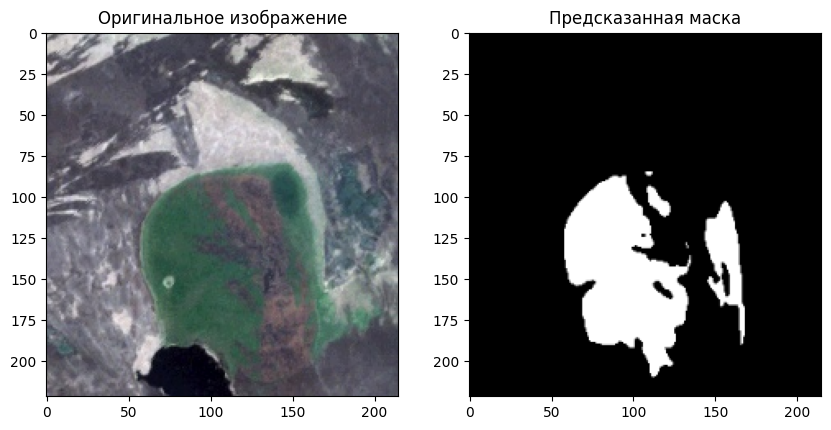

In [23]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path, device):
    image = Image.open(image_path).convert('RGB')

    H, W = image.size
    print(H,W)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Изменение размера изображения
        transforms.ToTensor(),          # Преобразование в тензор
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Нормализация
    ])
    
    image = transform(image).unsqueeze(0)  # Добавление batch size
    
    image = image.to(device)
    
    model.eval()
    
    with torch.no_grad():
        # Предсказание
        output = model(image)
    
    pred_mask = output.squeeze().cpu().numpy()  # Извлечение тензора и перевод на CPU
    pred_mask = (pred_mask > 0.05).astype('uint8')  # Бинаризация маски
    pred_mask = pred_mask * 255
    pred_mask = cv2.resize(pred_mask, (H, W)) 
    return pred_mask

# Визуализация оригинального изображения и предсказанной маски
def display_results(image_path, pred_mask):
    image = Image.open(image_path).convert('RGB')
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    axs[0].imshow(image)
    axs[0].set_title('Оригинальное изображение')
    
    axs[1].imshow(pred_mask, cmap='gray')
    axs[1].set_title('Предсказанная маска')
    
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

image_path = "/home/user/projects/co_hack_fires/train/full/train/images/0.jpg"

predicted_mask = predict_image(model, image_path, device)

display_results(image_path, predicted_mask)

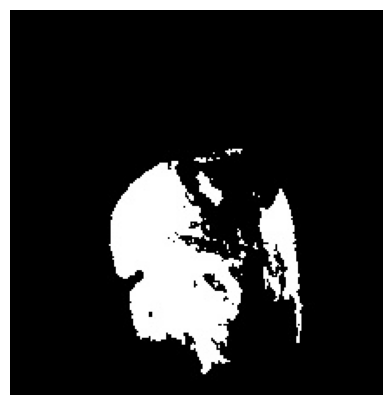

In [24]:
mask_path = "/home/user/projects/co_hack_fires/train/full/train/masks/0.jpg"
mask_orig= Image.open(mask_path).convert('RGB')

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(mask_orig)
ax.axis('off')
plt.show()

## Переписываем сеть

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.double_conv(in_channels, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv4 = self.double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = self.double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = self.double_conv(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc_conv4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec4 = self.dec_conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec_conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec_conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec_conv1(dec1)
        
        # Output
        output = self.output_conv(dec1)
        return output

# Пример инициализации модели
model = UNet(in_channels=3, out_channels=1)

# Остальная часть кода для обучения может остаться такой же
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (enc_conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

# Пробуем юнет с эмбеддингом

## pandas embeddings tabl csv

In [15]:
import pandas as pd

# Загрузка CSV файла
df = pd.read_csv("/home/user/projects/co_hack_fires/train/00/2021-06-06_weather.csv")

# Просмотр первых нескольких строк
df.head()

,Дата,Тсред,Тмин,Тмакс,Осадки всего,Направление ветра,Скорость ветра,Порывы ветра,Атмосферное Давление
0,2021-03-18,-5.8,-7.7,-3.6,0.0,240.0,17.5,NaN,1030.0
1,2021-03-19,-5.9,-8.5,-2.5,0.0,172.0,27.3,NaN,1023.4
2,2021-03-20,-2.2,-5.1,1.0,1.7,178.0,24.9,NaN,1002.3
3,2021-03-21,-0.8,-2.7,0.2,0.6,246.0,26.5,NaN,999.7
4,2021-03-22,-2.1,-4.0,0.0,1.0,223.0,11.6,NaN,1010.8


In [25]:
df = df.drop(['Порывы ветра', 'Дата'], axis=1)

In [29]:
df.tail()

,Тсред,Тмин,Тмакс,Осадки всего,Направление ветра,Скорость ветра,Атмосферное Давление
57,16.0,6.4,23.3,0.0,329.0,8.7,1024.5
58,22.3,15.3,29.9,0.1,258.0,16.8,1019.0
59,22.7,16.8,29.5,0.0,296.0,18.3,1014.2
60,23.8,12.4,32.2,0.0,266.0,17.7,1013.7
61,20.7,14.6,26.4,0.2,310.0,16.7,1009.6


In [35]:
# Преобразование DataFrame в тензор PyTorch
X = torch.tensor(df.values, dtype=torch.float32)

# Преобразование DataFrame в тензор PyTorch
X = torch.tensor(df.values, dtype=torch.float32)

# Определение модели
class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.fc1 = nn.Linear(in_features=df.shape[1], out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=1000)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Создание модели и получение эмбеддингов
model = EmbeddingModel()
embeddings = model(X)

# Присвоение весов строкам: большее значение весов для более низких строк
weights = torch.arange(1, len(df) + 1, dtype=torch.float32)
weights = weights / weights.sum()  # Нормализация весов, чтобы сумма весов была 1

# Применение весов и вычисление взвешенного среднего
weighted_embeddings = (embeddings * weights.view(-1, 1)).sum(dim=0, keepdim=True)
_, weighted_embedding_dim = weighted_embeddings.shape
print(weighted_embedding_dim)
print("Размер финального эмбеддинга:", weighted_embeddings.shape)
print("Финальный эмбеддинг:", weighted_embeddings)

1000
Размер финального эмбеддинга: torch.Size([1, 1000])
Финальный эмбеддинг: tensor([[ 2.3606e+01, -7.3029e+00,  1.0760e+01, -6.6161e+00, -7.7473e+00,
          2.8762e+00, -5.9249e-01, -9.5952e+00, -1.5220e+01, -2.3291e+01,
         -5.6330e+00, -1.4627e+01, -6.0964e+00, -1.2018e+01,  2.6980e+00,
          7.6582e+00,  3.3266e-01, -1.3300e+01,  1.5656e+01, -9.4050e+00,
         -4.7359e+00,  2.1186e+00, -2.1040e+01,  1.3027e+00,  1.6149e+01,
         -9.9716e+00, -4.7505e+00, -4.7775e-02,  1.8752e+01,  3.2476e+00,
         -1.5504e+01,  1.1174e+01,  2.3164e+01,  2.9228e+00,  8.9163e+00,
         -7.1817e+00, -1.3260e+01, -1.4434e+01, -1.0027e+01, -1.6304e+00,
          2.6715e+00,  1.3085e+01,  8.0158e+00, -3.2093e+01, -1.1476e+01,
          4.9963e+00,  2.7658e+01, -2.6289e+01, -5.3743e+00,  1.2357e+01,
          3.2869e+01,  8.3975e+00,  2.3377e+00,  1.9007e+01, -2.5330e-01,
         -1.9471e+01, -1.6715e+01, -1.5436e+01, -5.4187e+00, -1.6971e+01,
          5.7113e+00, -1.2266e+01,

## completed unet with csv embeddings in latent space

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetWithEmbeddings(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, embedding_dim=1000):
        super(UNetWithEmbeddings, self).__init__()
        
        # Encoder
        self.enc_conv1 = self.double_conv(in_channels, 64)
        self.enc_conv2 = self.double_conv(64, 128)
        self.enc_conv3 = self.double_conv(128, 256)
        self.enc_conv4 = self.double_conv(256, 512)
        
        # Bottleneck
        self.bottleneck = self.double_conv(512 + weighted_embedding_dim, 1024)  # Adjust input channels to include embeddings
        
        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec_conv4 = self.double_conv(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec_conv3 = self.double_conv(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec_conv2 = self.double_conv(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec_conv1 = self.double_conv(128, 64)
        
        # Output
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        # Embedding layer (if needed)
        self.embedding_layer = nn.Linear(weighted_embedding_dim, 1024)  # Map embeddings to the desired size

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, embeddings):
        # Encoder
        enc1 = self.enc_conv1(x)
        enc2 = self.enc_conv2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.enc_conv3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.enc_conv4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        
        # Bottleneck
        # Process embeddings and concatenate with bottleneck feature map
        embedding_features = self.embedding_layer(embeddings).view(embeddings.size(0), 1024, 1, 1)
        bottleneck_input = F.max_pool2d(enc4, kernel_size=2, stride=2)
        bottleneck_input = torch.cat((bottleneck_input, embedding_features), dim=1)
        bottleneck = self.bottleneck(bottleneck_input)
        
        # Decoder
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)  # Skip connection
        dec4 = self.dec_conv4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec_conv3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec_conv2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec_conv1(dec1)
        
        # Output
        output = self.output_conv(dec1)
        return output


RuntimeError: Tensors must have same number of dimensions: got 4 and 2